In [1]:
import requests
import os
import json
import asyncio
from dotenv import load_dotenv
load_dotenv()

import sys
PARENT_DIR = os.path.dirname(os.getcwd())
src_path = os.path.join(PARENT_DIR, '')
print(src_path)
sys.path.append(src_path)


/Users/shotomorisaki/Engineering/X-Developper-Challenge-Search/backend/


In [2]:
from Twitter.recent_search import recent_search
from Twitter.process_queries import analyze
from Twitter.rank_tweets import rank_tweets, similarity_scorer

DATA_DIR = os.path.join(os.getcwd(), "data")

/Users/shotomorisaki/Engineering/X-Developper-Challenge-Search/.venv/lib/python3.9/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
async def get_results(query):
    res = analyze(query)
    description = res["description"]
    subqueries = res["subqueries"]
    data = {"queries": []}

    async def fetch_and_format(query):
        search_result = recent_search(query, 10)
        formatted_result = json.dumps(json.loads(search_result), indent=4)
        return {"query": query, "results": formatted_result}

    fetch_tasks = [fetch_and_format(item) for item in subqueries]
    results = await asyncio.gather(*fetch_tasks)
    data["queries"].extend(results)

    with open("recent_search_queries.json", 'w') as file:
        json.dump(data["queries"], file, indent=4, sort_keys=True)
    sorted_tweets = await rank_tweets(data["queries"], description)
    return json.dumps([res, sorted_tweets], default=float)

In [4]:
result_container = get_results("NBA playoff")

In [5]:
result_container_load = await result_container  # Assuming result_container is a coroutine
result_container_str = json.dumps(result_container_load)
result_container_load = json.loads(result_container_str)
sorted_tweets = result_container_load[1]

[
    {
        "author_id": "1339725849965322241",
        "created_at": "2024-04-21T18:18:51.000Z",
        "edit_history_tweet_ids": [
            "1782111771509014680"
        ],
        "id": "1782111771509014680",
        "name": "Jana McCafferty",
        "profile_image_url": "https://pbs.twimg.com/profile_images/1607209982008741892/aDP0oyBa_normal.jpg",
        "text": "RT @BigGameBoomer: My favorite sports teams\n\nCollege: OU/K State\nNFL: Kansas City Chiefs\nMLB: Kansas City Royals\nNBA: OKC Thunder\nWNBA: Ind\u2026",
        "username": "FancyNancyJana1"
    },
    {
        "author_id": "1460277464119365638",
        "created_at": "2024-04-21T18:18:43.000Z",
        "edit_history_tweet_ids": [
            "1782111739238084613"
        ],
        "id": "1782111739238084613",
        "name": "x-Knicksolas",
        "profile_image_url": "https://pbs.twimg.com/profile_images/1552393160483127304/3WFnbAER_normal.jpg",
        "text": "RT @adamdigital: The NBA playoffs have been 

In [6]:
result_container = get_results("NBA playoff")
result_container_load = await result_container  # Assuming result_container is a coroutine

# Parsing the string as JSON
result_container_load = json.loads(result_container_load)

# Extracting the description from the first element of the list
tweets_data = result_container_load[1]

[
    {
        "author_id": "1339725849965322241",
        "created_at": "2024-04-21T18:18:51.000Z",
        "edit_history_tweet_ids": [
            "1782111771509014680"
        ],
        "id": "1782111771509014680",
        "name": "Jana McCafferty",
        "profile_image_url": "https://pbs.twimg.com/profile_images/1607209982008741892/aDP0oyBa_normal.jpg",
        "text": "RT @BigGameBoomer: My favorite sports teams\n\nCollege: OU/K State\nNFL: Kansas City Chiefs\nMLB: Kansas City Royals\nNBA: OKC Thunder\nWNBA: Ind\u2026",
        "username": "FancyNancyJana1"
    },
    {
        "author_id": "1460277464119365638",
        "created_at": "2024-04-21T18:18:43.000Z",
        "edit_history_tweet_ids": [
            "1782111739238084613"
        ],
        "id": "1782111739238084613",
        "name": "x-Knicksolas",
        "profile_image_url": "https://pbs.twimg.com/profile_images/1552393160483127304/3WFnbAER_normal.jpg",
        "text": "RT @adamdigital: The NBA playoffs have been 

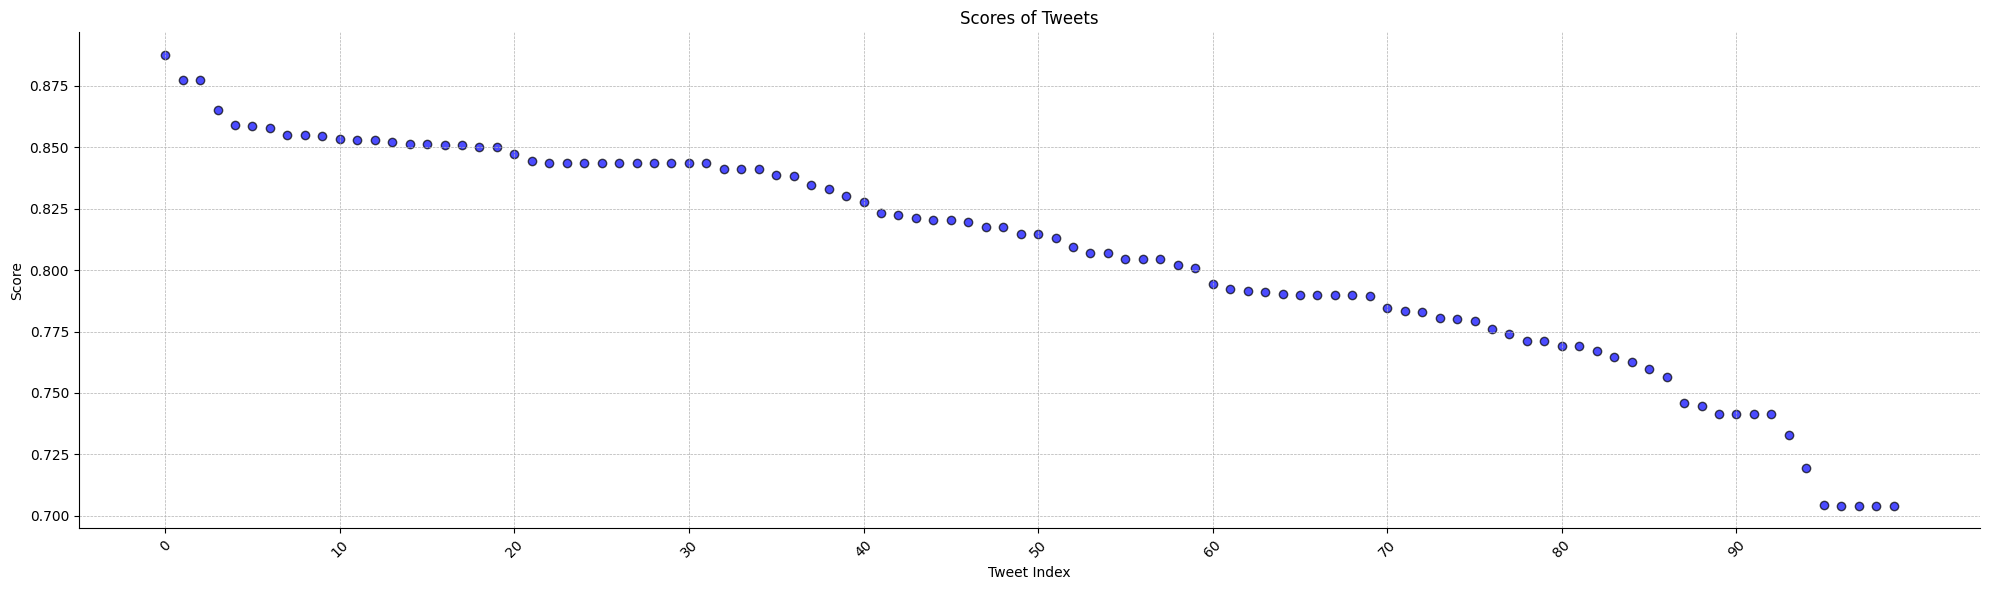

In [21]:
scores = [tweet["score"] for tweet in tweets_data]
texts = [tweet["tweet"]["text"] for tweet in tweets_data]

import matplotlib.pyplot as plt
import numpy as np

indices = range(len(texts))
Q1, Q2, Q3 = np.percentile(scores, [25, 50, 75])

plt.figure(figsize=(20, 6))
plt.scatter(indices, scores, color='blue', alpha=0.7, edgecolor='black')

# plt.axhline(y=Q1, color='black', linestyle='--', alpha=0.5, lw=2, label='1st Quartile (Q1)')
# plt.axhline(y=Q2, color='black', linestyle='--', alpha=0.5, lw=2, label='2nd Quartile (Median, Q2)')
# plt.axhline(y=Q3, color='black', linestyle='--', alpha=0.5, lw=2, label='3rd Quartile (Q3)')

# Labels & Title
plt.xlabel('Tweet Index')
plt.ylabel('Score')
plt.title('Scores of Tweets')

# Improve readability
plt.xticks(indices[::len(indices)//10], rotation=45)  # Show only a selection of indices
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()